# IUM PROJEKT

## Autorzy
Mateusz Krakowski \
Grzegorz Socha

## Słowniczek

kliknięcie - wykonanie operacji "PLAY" przez użytkownika \
interwał czasowy - odstęp w skwantowanym czasie

## Kontekst
Portal muzyczny „Pozytywka”, który swoim użytkownikom pozwala na odtwarzanie ulubionych utworów
online.
### Zadanie
“Nasz serwis zarabia wtedy, gdy ludzie słuchają muzyki. Jeśli nie wiemy ile czasu będą słuchali
jej w przyszłości, to trudno nam rozliczać się z artystami i negocjować z nimi stawki”.

## Problem biznesowy
Nasz serwis, jak większość popularnych serwisów streamingowych działa w modelu "freemium" - darmowy dostęp do serwisu okraszonego reklamami z możliwością pozbycia się ich poprzez zakupienie premium. Serwis musi płacić artystom należną im kwotę ustaloną wcześniej. Naszym zadaniem jest stworzenie modelu predykcyjnego, który pozwoli na oszacowanie jak wiele "kliknięć" przyciągnie twórczość danego artysty. Dzięki predykcji portal "Pozytywka" będzie miał ułatwienie w podejmowaniu decyzji odnośnie wysokości stawek dla artystów.

Interesują nas tutaj kliknięcia zamiast pełnych wysłuchań utworów, gdyż zakładamy że to właśnie kliknięcie może wywołać reklamę, a co za tym idzie przynieść zyski.

## Biznesowe kryterium sukcesu
Otrzymanie predykcji które ułatwią portalowi "Pozytywka" podejmowanie decyzji w sprawie kontraktów z artystami. W przypadku spadającej popularności artysty portal będzie mógł zerwać kontrakt, w przypadku rosnącej popularności portal będzie mógł pozwolić na zwiększenie stawki.

## Zadanie modelowania:
Musimy rozwiązać problem analizy szeregów czasowych w celu przewidzenia ilości odtworzeń
utworów danego artysty w przyszłości. Na podstawie predykcji modelu będziemy mogli ustalić,
czy artysta będzie zyskiwał na popularności, a co za tym idzie, czy możemy pozwolić na zwięk-
szenie jego stawki kwotowej.
W celu rozwiązania problemu stworzone zostaną dwa modele predykcyjne:
- zaawansowany model korzystający z metody ARIMA
- prosty model naiwny

Danymi wejściowymi będą wartości ilości kliknięć utworów poszczególnych artystów w każdym z interwałów czasowych. Obecnie proponujemy interwały miesięczne dlatego, że na rynku europejskim popularne jest rozliczanie się co miesiąc. \
Zmienną celu jest ilość kliknięć użytkowników które przyciągnęła twórczość danego artysty w przyszłych miesiącach, które możemy szacować przez predykcję.

## Analityczne kryterium sukcesu
Otrzymanie predykcji z błędem nie przekraczającym wartości alfa. MSE(error) = alfa. alfa = do ustalenia.
Błąd możemy obliczyć poprzez nieuwzględnienie ostatniego interwału czasowego w modelu, w celu porównania predykcji do danych które mamy.

## Analiza otrzymanych danych pod względem poprawności
Pełna analiza w oddzielnych plikach

## Dane v1

Na drodze analizy przysłanych danych odkryliśmy następujące błędy:

- 327 artystów z bazy jako id ma podaną wartość "-1" np. "Skrillex" czy "Earth, Wind and Fire"
- wiele rekordów sesji użytkowników jest wybrakowana, brakuje takich pól jak: user\_id, track\_id, event\_type(przyjmują wartość null)
- podobny problem występuje w danych piosenek, tym razem wartości null występują w polach: id, name, popularity, id\_artist

Dodatkowo danych sesji jest za mało aby dokonywać predykcji na temat popularności piosenek. \
Niestety, przysłane dane nie pozwolą na rozwiązanie problemu. Wymagane było ponowne poproszenie o dane.


## Dane v2

Na drodze analizy udało nam się ustalić że dane są kompletne oraz wyeliminowano błędy opisane w v1, Dodatkowo:
- zwiększyła się ilość artystów oraz utworów
- kluczowa dla nas jest duża ilość danych sesji użytkowników, porównując do poprzedniej wersji danych
- dane sesji dotyczą jedynie 808 artystów z bazy 28 tysięcy, oznacza to, że proponowany przez nas model możemy zastosować jedynie do tych 808 artystów.
- Na dodatek jedynie 491 artystów zostało wysłuchanych przynajmniej raz w każdym z miesiąców. \

## Wnioski z analizy danych:
- Możemy dokonywać predykcji
- predykcje mogą być wykonywane tylko dla artystów dla których mamy wystarczająco dużo danych
- predykcje powynny być lepsze dla popularnych artystów
- lepiej by było gdybyśmy mieli pełne dane sesji użytkowników, nie tylko wybrane(808/27524 artystów posiadających wysłuchania ich utworów, ciężko uwieżyć że nikt nie słuchał np. Skrillexa)

In [287]:
import pandas as pd
from dateutil import parser
from datetime import date
import matplotlib.pyplot as plt

In [288]:
artists = pd.read_json("data/v2/artists.jsonl", lines=True)
sessions = pd.read_json("data/v2/sessions.jsonl", lines=True)
track_storage = pd.read_json("data/v2/track_storage.jsonl", lines=True)
tracks = pd.read_json("data/v2/tracks.jsonl", lines=True)
users = pd.read_json("data/v2/users.jsonl", lines=True)

pd.set_option('mode.chained_assignment', None)

## Funkcje pomocnicze do analizy danych


In [289]:
def get_month(date):
    return date.month + (date.year - 2020) * 12


## Analiza danaych pod względem rozwiązania

In [290]:
sessions_played = sessions[sessions['event_type'] == 'PLAY']

# Sort by timestamp
sessions_played = sessions_played.sort_values(by=['timestamp']) 
# zakres od 2022-01-03 do 2022-12-05 - dane podzielimy na miesiące po to aby zachować regularność  2022-01-03 - poniedziałek  2022-12-05 - poniedziałek

In [291]:

sessions_played = sessions[sessions['event_type'] == 'PLAY']

# Sort by timestamp
sessions_played = sessions_played.sort_values(by=['timestamp'])
# zakres od 2022-01-03 do 2022-12-05 - dane podzielimy na tygodnie po to aby zachować regularność

# merge sessions played with tracks
sessions_played = sessions_played.merge(tracks, left_on='track_id', right_on='id', how='left')

sessions_played = sessions_played.merge(artists, left_on='id_artist', right_on='id', how='left')


In [292]:
#delete rows where timestamp is grater then 2022-12-01 #TODO DELETE THIS IN GENERIC MODEL

# removed december because only 5 days of data are available
sessions_played = sessions_played[sessions_played['timestamp'] < '2022-12-01']

# change name of colujm name_y to artist, name_x to track
sessions_played = sessions_played.rename(columns={'name_y': 'artist', 'name_x': 'track'})

# count the number of all unique artisits
unique_artists = sessions_played['artist'].unique()

sessions_played['month'] = sessions_played['timestamp'].apply(get_month)

artist_clicks = sessions_played.groupby(['artist', 'month']).size().reset_index(name='play_count')


artist_clicks

print(f"unique artists: {len(unique_artists)}")


unique artists: 808


In [293]:
artist_clicks_dictionary = {}
artist_lisined_to_every_month = []

max_month = max(artist_clicks['month'])
min_month = min(artist_clicks['month'])

for artist in unique_artists:
    artist_clicks_dictionary[artist] = artist_clicks[artist_clicks['artist'] == artist].drop(columns=['artist']).set_index('month').to_dict()['play_count']

    if len(artist_clicks_dictionary[artist]) == max_month - min_month + 1:
        artist_lisined_to_every_month.append(artist)


# if artist listened to every month add to list


for artist in artist_clicks_dictionary:
    if len(artist_clicks_dictionary[artist]) < 12:


        for i in range(min_month, max_month+1):
            if i not in artist_clicks_dictionary[artist]:
                artist_clicks_dictionary[artist][i] = 0
    

print(f"Number of artists that were listened to every month: {len(artist_lisined_to_every_month)}")



Number of artists that were listened to every month: 491


## Dane wejściowe
Będzie to słownik których kluczem będzie nazwa artysty/zespołu, natomiast wartością będzie kolejny słownik, tym razem z parami miesiąc:ilość kliknięć. 
Przykład elementu słownika:



In [297]:
artist_clicks_dictionary["XXXTENTACION"]


Sonata Arctica
Bruce Dickinson
Kansas
Declan McKenna
Anthrax
Atlanta Rhythm Section
The Bangles
L.A. Guns
The White Stripes
Ghost
Ry Cooder
Derek & The Dominos
Stone Temple Pilots
DOWN
Alex Turner
The Paul Butterfield Blues Band
Dokken
Manic Street Preachers
Jeff Buckley
Willie Dixon
Napalm Death
The Psychedelic Furs
Falling In Reverse
Badfinger
John Mellencamp
Bonnie Raitt
Everclear
Courteeners
Kingdom Come
The Lovin' Spoonful
Soundgarden
Jimmy Eat World
Muse
Foghat
Bush
Jon Bon Jovi
George Thorogood & The Destroyers
Tommy James & The Shondells
Patti Smith
John Hiatt
Little Walter
Satyricon
Tony Joe White
Elbow
Lenny Kravitz
Eddie Money
Free
Earl Hooker
Interpol
Mayhem
Live
Triumph
Violent Femmes
HammerFall
Screamin' Jay Hawkins
Jet
Blackfoot
38 Special
Survivor
Modest Mouse
Clutch
Stereophonics
Mississippi Fred McDowell
Our Lady Peace
Elvis Costello
Kokomo Arnold
Hole
Faces
Doves
Night Ranger
John Fogerty
Popa Chubby
Sheryl Crow
Beck
The Verve
Krokus
PJ Harvey
Junior Wells
Audioslave

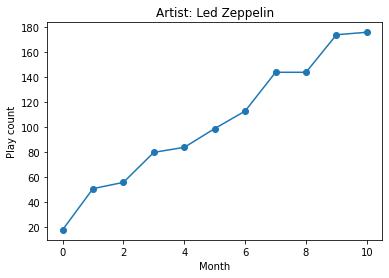

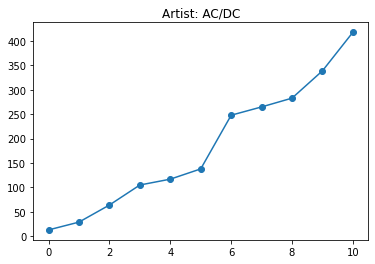

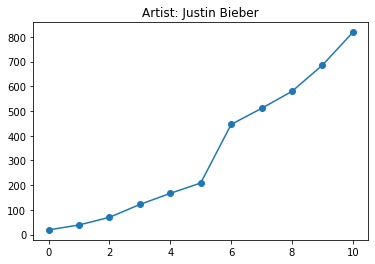

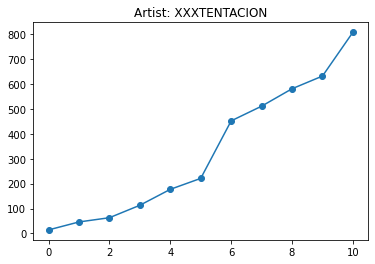

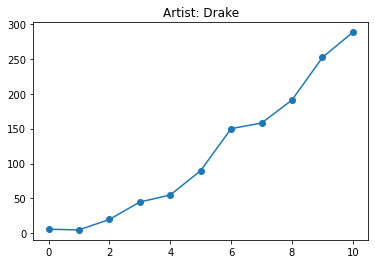

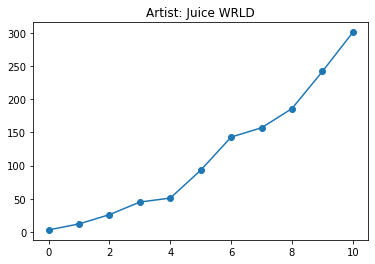

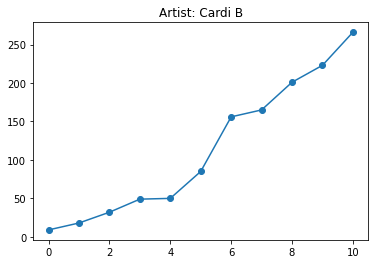

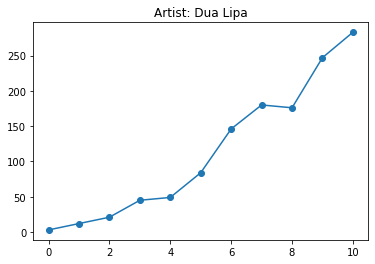

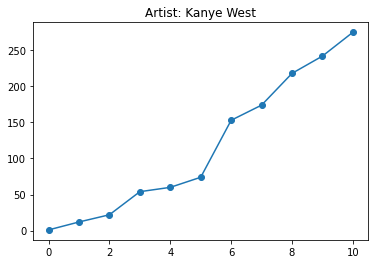

In [295]:
NUMBER_OF_ARTISTS_TO_PLOT = 10
ARTISTS_POPULAR = ["Kanye West", "Justin Bieber", "Juice WRLD", "Dua Lipa", "Drake", "Cardi B", "Led Zeppelin", "AC/DC", "XXXTENTACION"]
ARTISTS_LESS_POPULAR = ["Amorphis", "Angra", "Biffy Clyro", "Beck", "Ghost", "Viola Beach", "Gov't Mule"]
fully_plotted_artists = []
plt.xlabel("Month")
plt.ylabel("Play count")
#plot artists from artists_clicks_dictionary
for artist in artist_clicks_dictionary:
    if len(fully_plotted_artists) < NUMBER_OF_ARTISTS_TO_PLOT:
        if artist in ARTISTS_POPULAR:
            plt.title(f"Artist: {artist}")
            plt.plot(artist_clicks_dictionary[artist].values(), label=artist ,marker='o')
            plt.show()
            fully_plotted_artists.append(artist)






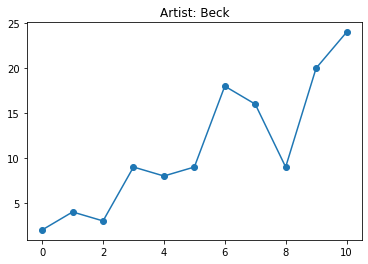

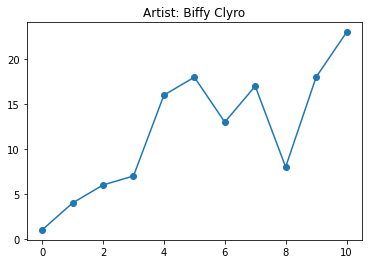

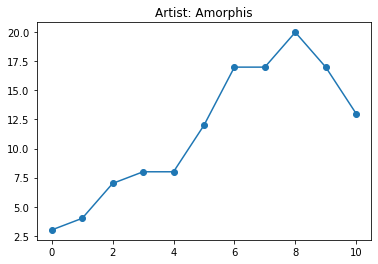

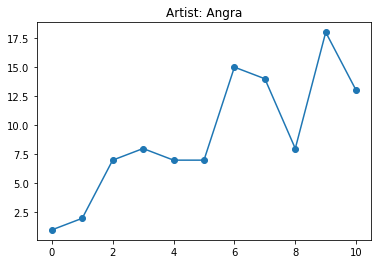

In [296]:
NUMBER_OF_ARTISTS_TO_PLOT = 10

fully_plotted_artists = []

for artist in artist_clicks_dictionary:
    if len(fully_plotted_artists) < NUMBER_OF_ARTISTS_TO_PLOT:
        if artist in ARTISTS_LESS_POPULAR:
            plt.title(f"Artist: {artist}")
            plt.plot(artist_clicks_dictionary[artist].values(), label=artist ,marker='o')
            plt.show()
            fully_plotted_artists.append(artist)

### Wnioski z analizy danych:

Widoczny jest stabilny wzrost popularności z miesiąca na miesiąc dla twórców o dużej renomie, tego samego nie można powiedzieć o artytstach mniej popularnych. Zauważalny jednak jest trend wzrostowy, mimo wachań w ilościach wysłuchań.

## Dalsze działania:
- Zastosowanie modeli predykcyjnych
- zwiększenie ilości danych
